## Module imports

In [53]:
# this is a bit of a hack to get relative imports
# to work as if these notebooks were in a package
# change cwd to project root if 'notebooks' in PATH
from os import chdir
from pathlib import Path

if "notebooks" in str(Path.cwd()):
    chdir("..")


import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import src.constants as const
from src.schemas import DataCatalog
from src.various_methods import (
    PlotCounter,
    month_num_to_cos,
    month_num_to_sin,
    get_workingdays,
)
from src.simulation_schemas import PopulationScenarios


## Notebook Constants

In [54]:
OLD_AGE_OVER = 65
WORKING_AGE = 20
REGIONAL_APPOINTMENTS_CATALOG_NAME = "NHS GP Appointments by Region"
HISTORICAL_APPOINTMENTS_CATALOG_NAME = "NHS GP Appointments by Region, historical"
APPOINTMENTS_START_DATE = dt.date(2022, 4, 1)
NOTEBOOK_ALIAS = "num_appointments"

## Load Catalog

In [55]:
# load data catalog
catalog = DataCatalog.load_from_yaml("data_catalog.yaml")
plot_counter = PlotCounter(name=NOTEBOOK_ALIAS)

# Data loading
## Appointments SUB-ICB level

In [56]:
USED_APPOINTMENT_COLUMNS = ["SUB_ICB_LOCATION_CODE","APPOINTMENT_MONTH","HCP_TYPE","COUNT_OF_APPOINTMENTS"]

In [57]:
def load_all_areas_gp_appts(catalog_entry_name:str) ->pd.DataFrame:
    
    catalog_entry = catalog.get_catalog_entry_by_name(catalog_entry_name)
    _ = catalog_entry.load()

    dfs_ = []
    for ccg_name in catalog_entry.zip_file.namelist():
        catalog_entry.csv_file = ccg_name
        dfs_.append(catalog_entry.load())

    combined_df_ = pd.concat(dfs_, axis=0)

    combined_df_ = combined_df_.rename(columns={'CCG_CODE':'SUB_ICB_LOCATION_CODE',
                                                          'Appointment_Month':'APPOINTMENT_MONTH'})
    
    combined_df_ = combined_df_.loc[:,USED_APPOINTMENT_COLUMNS]
    try:
        combined_df_['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df_['APPOINTMENT_MONTH'])
    except:
        combined_df_['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df_['APPOINTMENT_MONTH'], format='%b-%y')
    
    return combined_df_

latest_gp_appts_df = load_all_areas_gp_appts(REGIONAL_APPOINTMENTS_CATALOG_NAME)
historical_gp_appts_df = load_all_areas_gp_appts(HISTORICAL_APPOINTMENTS_CATALOG_NAME)
historical_gp_appts_df = historical_gp_appts_df.loc[~historical_gp_appts_df['APPOINTMENT_MONTH'].isin(latest_gp_appts_df['APPOINTMENT_MONTH'].unique())]
all_area_appts_df = pd.concat([latest_gp_appts_df, historical_gp_appts_df], axis=0)

/tmp/ipykernel_5921/2757400239.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df_['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df_['APPOINTMENT_MONTH'])
/tmp/ipykernel_5921/2757400239.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df_['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df_['APPOINTMENT_MONTH'])


In [58]:
all_area_appts_df.dtypes

SUB_ICB_LOCATION_CODE            object
APPOINTMENT_MONTH        datetime64[ns]
HCP_TYPE                         object
COUNT_OF_APPOINTMENTS             int64
dtype: object

## Exploration

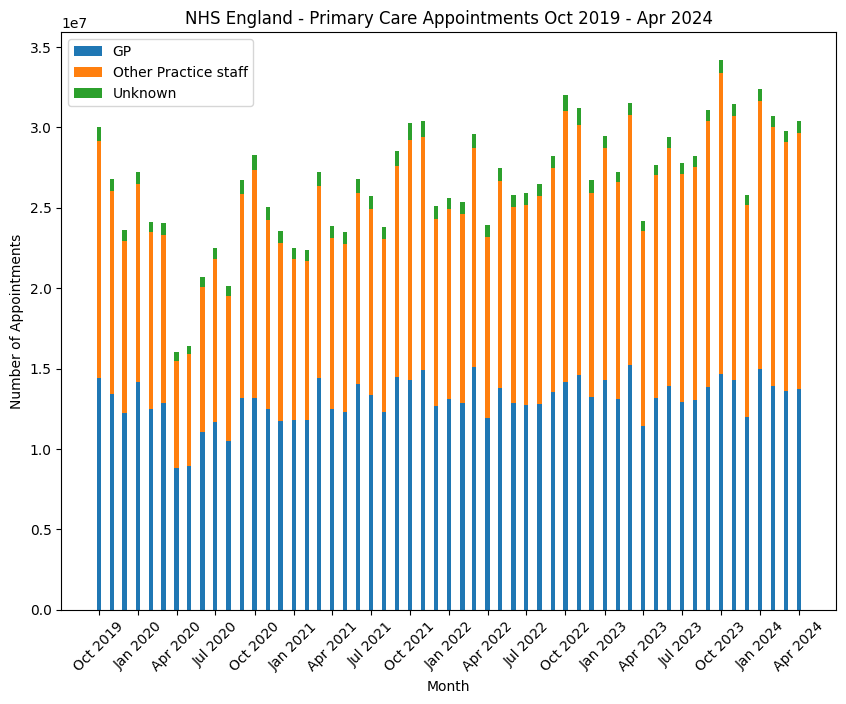

In [59]:
def stacked_bar_appointments(
    df: pd.DataFrame, title: str, ylabel: str, xlabel: str, figsize=(10, 7.5)
):
    fig, ax = plt.subplots(figsize=figsize)

    months = df["APPOINTMENT_MONTH"].dt.date.unique()

    bottoms = np.zeros(len(months))
    for hcp_type in df["HCP_TYPE"].unique():
        hcp_type_slice = df[df["HCP_TYPE"] == hcp_type].copy()
        p = ax.bar(
            months,
            hcp_type_slice["COUNT_OF_APPOINTMENTS"].values,
            width=10,
            bottom=bottoms,
            label=hcp_type,
        )
        bottoms += hcp_type_slice["COUNT_OF_APPOINTMENTS"].values
    date_range = (
        str([f"{i.strftime('%b %Y')}" for i in [months.min(), months.max()]])[1:-1]
        .replace("'", "")
        .replace(",", " -")
    )
    ax.set_title(f"{title} {date_range}")
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.tick_params(axis="x", rotation=45)
    ax.legend()
    plt.savefig(f"{plot_counter.plot_name}.png")
    plt.show()


stacked_bar_appointments(
all_area_appts_df.groupby(["APPOINTMENT_MONTH", "HCP_TYPE"])[
    ["COUNT_OF_APPOINTMENTS"]
]
.sum()
.reset_index(),
"NHS England - Primary Care Appointments",
"Number of Appointments",
"Month",
)

No obvious seasonality

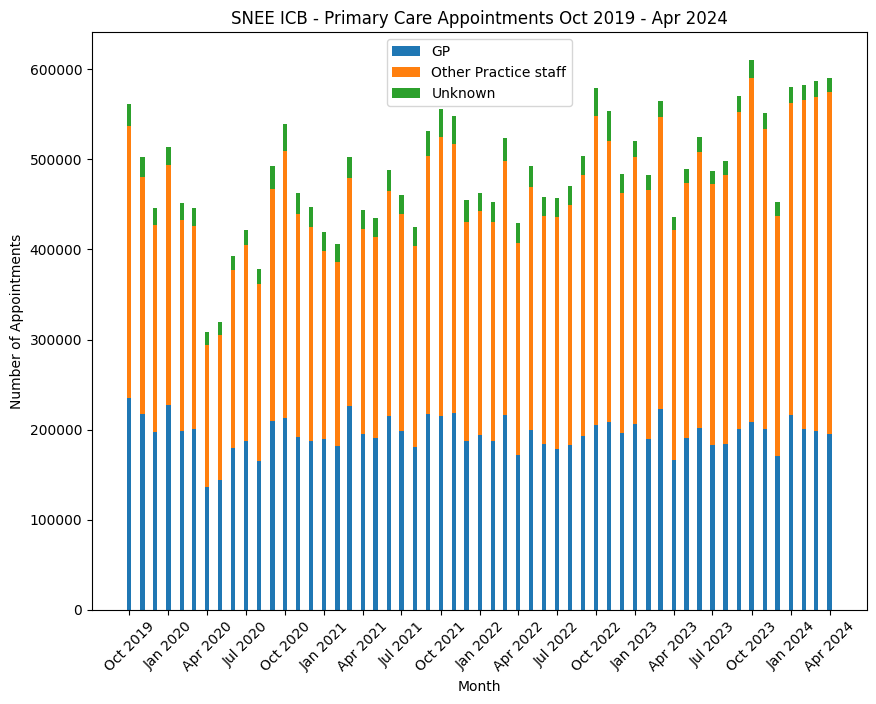

In [60]:
snee_appointments_df = (
    all_area_appts_df.loc[
        all_area_appts_df["SUB_ICB_LOCATION_CODE"].isin(
            list(const.SUB_ICB_CODES.keys())
        )
    ]
    .groupby(["APPOINTMENT_MONTH", "HCP_TYPE"])[["COUNT_OF_APPOINTMENTS"]]
    .sum()
    .reset_index()
)
stacked_bar_appointments(
    snee_appointments_df,
    "SNEE ICB - Primary Care Appointments",
    "Number of Appointments",
    "Month",
)

## EDA

In [61]:
# divide by working days/month to get average appointments per day
monthly_appts_df = snee_appointments_df.groupby('APPOINTMENT_MONTH').sum(numeric_only=True)
monthly_appts_df = monthly_appts_df.assign(WORKING_DAYS=get_workingdays(monthly_appts_df.index))
monthly_appts_df = monthly_appts_df.assign(AVG_APPTS_PER_WORKING_DAY=monthly_appts_df['COUNT_OF_APPOINTMENTS'] / monthly_appts_df['WORKING_DAYS'])

### Clear seasonality

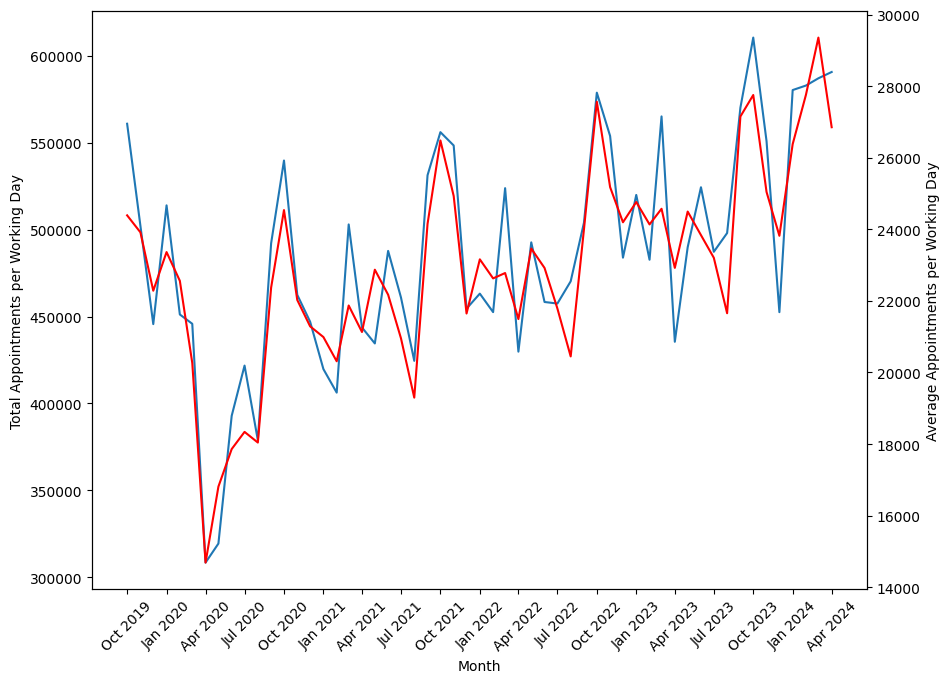

In [62]:
fig, ax = plt.subplots(figsize=(10, 7.5))
ax2 = ax.twinx()
ax.plot(monthly_appts_df['COUNT_OF_APPOINTMENTS'])
ax2.plot(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], color='r')
# y axis title
ax2.set_ylabel('Average Appointments per Working Day')
# x axis title
ax.set_ylabel('Total Appointments per Working Day')
# x axis title
ax.set_xlabel('Month')

# change x axis format to month, year
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
# rotate x axis labels
ax.tick_params(axis='x', rotation=45)
plt.show()

### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)


## Feature Engineering

### Convert population to proportions of population

In [63]:
# keep gendered data, and age groups
def convert_gp_list_to_five_year_bins(df: pd.DataFrame) -> pd.Series:
    """
    Converts the GP list dataframe to a new dataframe with age groups grouped into five-year bins.

    Args:
        gp_list_df (pd.DataFrame): The input GP list dataframe.

    Returns:
        pd.DataFrame: The converted dataframe with age groups grouped into five-year bins.
    """

    # Filter the GP list dataframe based on specific conditions
    gp_list_df_ = df.loc[
        (df["ORG_TYPE"] == "SUB_ICB_LOCATION")
        & (df["SEX"] != "ALL")
        & (df["AGE_GROUP_5"] != "ALL")
    ].copy()

    # Select specific columns from the filtered dataframe
    gp_list_df_ = gp_list_df_.loc[:, ["ORG_CODE", "SEX", "AGE_GROUP_5", "NUMBER_OF_PATIENTS"]]

    # Modify the age group values
    gp_list_df_["AGE_GROUP_5"] = gp_list_df_["AGE_GROUP_5"].replace(
        {"90_94": "90+", "95+": "90+"}
    )
    gp_list_df_["AGE_GROUP_5"] = gp_list_df_["AGE_GROUP_5"].str.replace("_", "-")

    # Pivot table to get age group as columns
    gp_list_df_ = gp_list_df_.pivot_table(
        index="ORG_CODE", columns="AGE_GROUP_5", values="NUMBER_OF_PATIENTS", aggfunc="sum"
    )
    return gp_list_df_


def convert_5_year_gp_list_to_proportional(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts a DataFrame of 5-year GP appointment counts to proportional values.

    Args:
        df (pd.DataFrame): The input DataFrame containing 5-year GP appointment counts.

    Returns:
        pd.DataFrame: The DataFrame with the appointment counts converted to proportional values.
    """
    total_appointments = df.div(df.sum(axis=1), axis=0)
    return total_appointments


# apply the functions

gp_list_proportional_areas_df = (gp_list_df
                                 .pipe(convert_gp_list_to_five_year_bins)
                                 .pipe(convert_5_year_gp_list_to_proportional))

gp_list_5yr_bins:pd.DataFrame = gp_list_df.pipe(convert_gp_list_to_five_year_bins)
gp_list_area_totals:pd.Series = gp_list_5yr_bins.sum(axis=1)
gp_list_area_totals.name = "NUMBER_OF_PATIENTS"


In [64]:
gp_list_proportional_areas_df

AGE_GROUP_5,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,5-9,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
ORG_CODE,,,,,,,,,,,,,,,,,,,
00L,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,0.055354,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00N,0.046318,0.056702,0.052957,0.048391,0.058945,0.071641,0.073194,0.066699,0.056026,0.054780,0.066198,0.072568,0.070651,0.060197,0.049951,0.042973,0.025699,0.017080,0.009032
00P,0.045493,0.056224,0.055058,0.054358,0.066509,0.074500,0.071698,0.064883,0.055768,0.052966,0.067178,0.069287,0.066296,0.058151,0.049276,0.042159,0.025396,0.016355,0.008447
00Q,0.056114,0.073327,0.069254,0.062584,0.067123,0.071613,0.073718,0.071445,0.061244,0.067286,0.065642,0.061721,0.053456,0.043510,0.036411,0.030505,0.018341,0.010841,0.005862
00R,0.046429,0.056044,0.054101,0.050338,0.059426,0.070912,0.069837,0.062282,0.055081,0.054717,0.069495,0.076881,0.070049,0.057242,0.047807,0.045427,0.028257,0.017382,0.008293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D9Y0V,0.044754,0.057723,0.054875,0.056655,0.061111,0.066157,0.066390,0.064362,0.059042,0.053581,0.065510,0.069489,0.065309,0.054914,0.050100,0.049306,0.030324,0.019025,0.011373
M1J4Y,0.056761,0.067081,0.059510,0.054228,0.068206,0.077507,0.081208,0.077654,0.066476,0.064680,0.064208,0.061501,0.053169,0.042478,0.036131,0.031448,0.019132,0.012090,0.006532
M2L0M,0.044474,0.058734,0.057799,0.048705,0.055575,0.062171,0.062580,0.059900,0.056298,0.053308,0.069734,0.074576,0.069721,0.058681,0.054886,0.051284,0.032140,0.018948,0.010486


#### Find total appointments per sub-icb per month with the list size

In [65]:
# total appointments per sub-icb per month with the list size


all_area_appts_df = (
    all_area_appts_df.loc[
        :, ["SUB_ICB_LOCATION_CODE", "APPOINTMENT_MONTH", "COUNT_OF_APPOINTMENTS"]
    ]
    .groupby(["SUB_ICB_LOCATION_CODE", "APPOINTMENT_MONTH"])[["COUNT_OF_APPOINTMENTS"]]
    .sum()
    .reset_index()
)
all_area_appts_df = (
    all_area_appts_df.set_index("SUB_ICB_LOCATION_CODE")
    .join(gp_list_area_totals)
    .reset_index()
)
all_area_appts_df.index.name ='SUB_ICB_LOCATION_CODE'
all_area_appts_df

,index,APPOINTMENT_MONTH,COUNT_OF_APPOINTMENTS,NUMBER_OF_PATIENTS
SUB_ICB_LOCATION_CODE,,,,
0,00L,2019-10-01,203441,337246
1,00L,2019-11-01,177033,337246
2,00L,2019-12-01,156654,337246
3,00L,2020-01-01,181879,337246
4,00L,2020-02-01,157515,337246
...,...,...,...,...
5825,X2C4Y,2023-12-01,238157,457030
5826,X2C4Y,2024-01-01,294641,457030
5827,X2C4Y,2024-02-01,269876,457030


#### Number of appointments per month per person

(considers the 2023 population only)

In [66]:
# calculate appointments per person per month
all_area_appts_df = all_area_appts_df.assign(
    gp_appts_per_person=lambda df: df["COUNT_OF_APPOINTMENTS"] / df["NUMBER_OF_PATIENTS"]
).drop(columns=["COUNT_OF_APPOINTMENTS", "NUMBER_OF_PATIENTS"])
all_area_appts_df

,index,APPOINTMENT_MONTH,gp_appts_per_person
SUB_ICB_LOCATION_CODE,,,
0,00L,2019-10-01,0.603242
1,00L,2019-11-01,0.524937
2,00L,2019-12-01,0.464510
3,00L,2020-01-01,0.539307
4,00L,2020-02-01,0.467063
...,...,...,...
5825,X2C4Y,2023-12-01,0.521097
5826,X2C4Y,2024-01-01,0.644686
5827,X2C4Y,2024-02-01,0.590500


### Add Working days/month
- Calculate appointments per working day
- drop unused columns

In [67]:
# get working days/month
all_area_appts_df["working_days"] = get_workingdays(
    all_area_appts_df["APPOINTMENT_MONTH"].dt
)
# calculate appointments per person per working day
all_area_appts_df["appts_per_person_per_workingday"] = (
    all_area_appts_df["gp_appts_per_person"] / all_area_appts_df["working_days"]
)
# get the month as a number
all_area_appts_df["month"] = all_area_appts_df["APPOINTMENT_MONTH"].dt.month
# drop columns
all_area_appts_df = all_area_appts_df.drop(
    columns=["working_days", "gp_appts_per_person", "APPOINTMENT_MONTH"]
)
all_area_appts_df

,index,appts_per_person_per_workingday,month
SUB_ICB_LOCATION_CODE,,,
0,00L,0.026228,10
1,00L,0.024997,11
2,00L,0.023225,12
3,00L,0.024514,1
4,00L,0.023353,2
...,...,...,...
5825,X2C4Y,0.027426,12
5826,X2C4Y,0.029304,1
5827,X2C4Y,0.028119,2


In [68]:
complete_dataset_df = all_area_appts_df.set_index("index").join(gp_list_proportional_areas_df)

complete_dataset_df

,appts_per_person_per_workingday,month,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,...,5-9,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
00L,0.026228,10,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00L,0.024997,11,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00L,0.023225,12,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00L,0.024514,1,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00L,0.023353,2,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X2C4Y,0.027426,12,0.050808,0.065057,0.061587,0.061451,0.069243,0.070724,0.070717,0.067488,...,0.060226,0.067737,0.065565,0.057215,0.047375,0.042236,0.038210,0.022786,0.014028,0.007402
X2C4Y,0.029304,1,0.050808,0.065057,0.061587,0.061451,0.069243,0.070724,0.070717,0.067488,...,0.060226,0.067737,0.065565,0.057215,0.047375,0.042236,0.038210,0.022786,0.014028,0.007402
X2C4Y,0.028119,2,0.050808,0.065057,0.061587,0.061451,0.069243,0.070724,0.070717,0.067488,...,0.060226,0.067737,0.065565,0.057215,0.047375,0.042236,0.038210,0.022786,0.014028,0.007402
X2C4Y,0.028662,3,0.050808,0.065057,0.061587,0.061451,0.069243,0.070724,0.070717,0.067488,...,0.060226,0.067737,0.065565,0.057215,0.047375,0.042236,0.038210,0.022786,0.014028,0.007402


## PCA

### Find the best PCA model for predicting average appointments/person

In [69]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

test_set = complete_dataset_df.loc[complete_dataset_df.index.isin(const.SUB_ICB_CODES.keys())]
train_set = complete_dataset_df.loc[~complete_dataset_df.index.isin(const.SUB_ICB_CODES.keys())]

PCA_COLS = ['0-4', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '5-9', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90+']
TARGET__COL = 'appts_per_person_per_workingday'

# Select the relevant columns from complete_dataset_df
X_train = train_set[PCA_COLS]
y_train = train_set[TARGET__COL]

y_test = test_set[TARGET__COL]
X_test = test_set[PCA_COLS]

# Perform PCA on the age groups
pca = PCA(n_components=3)
X_train_trans = pca.fit_transform(X_train)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train_trans, y_train)

# Predict appts_per_person_per_workingday using the PCA of age groups
y_pred = model.predict(pca.transform(X_test))


In [78]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer to allow parameter selection for different PCA methods
class CustomPCA(BaseEstimator, TransformerMixin):
    def __init__(self, method='PCA', n_components=2, kernel='linear'):
        self.method = method
        self.n_components = n_components
        self.kernel = kernel
        self.pca_ = None

    def fit(self, X, y=None):
        if self.method == 'PCA':
            self.pca_ = PCA(n_components=self.n_components)
        elif self.method == 'KernelPCA':
            self.pca_ = KernelPPA(n_components=self.n_components, kernel=self.kernel)
        elif self.method == 'SparsePCA':
            self.pca_ = SparsePCA(n_components=self.n_components)
        self.pca_.fit(X)
        return self

    def transform(self, X):
        return self.pca_.transform(X)

    def get_params(self, deep=True):
        return {'method': self.method, 'n_components': self.n_components, 'kernel': self.kernel}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

def find_best_pca_for_forecasting(df, age_columns, target_column, n_components_range=[2, 5, 10], kernel_options=['linear', 'poly', 'rbf']):
    # Prepare the features and target variable
    X = df[age_columns]
    y = df[target_column]
    
    # Define the parameter grid
    param_grid = [
        { 'pca__method': ['PCA'], 'pca__n_components': n_components_range },
        { 'pca__method': ['KernelPCA'], 'pca__n_components': n_components_range, 'pca__kernel': kernel_options },
        { 'pca__method': ['SparsePCA'], 'pca__n_components': n_components_range },
    ]

    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', CustomPCA()),  # Custom PCA wrapper
        ('regressor', LinearRegression())
    ])

    # Define the scoring metrics
    scoring = {
        'R2': 'r2',
        'MSE': 'neg_mean_squared_error',
        'MAE': 'neg_mean_absolute_error',
        'ExplainedVariance': 'explained_variance'
    }

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, refit='R2', return_train_score=True)
    grid_search.fit(X, y)
    
    # Get the best estimator
    best_pipeline = grid_search.best_estimator_
    
    # Split the data into training and test sets for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the best pipeline on the training data
    best_pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = best_pipeline.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    explained_variance = explained_variance_score(y_test, y_pred)
    
    # Extract grid search results
    grid_results = pd.DataFrame(grid_search.cv_results_)
    
    # Add test set evaluation metrics to the DataFrame
    test_metrics = {
        'Metric': ['R²', 'MSE', 'RMSE', 'MAE', 'Explained Variance'],
        'Score': [r2, mse, rmse, mae, explained_variance]
    }
    test_metrics_df = pd.DataFrame(test_metrics)
    
    # Concatenate grid search results and test metrics
    results_df = pd.concat([grid_results, test_metrics_df], axis=1, ignore_index=False)

    return best_pipeline, results_df

# Example of how to use this function:
# df = pd.read_csv('your_data.csv')  # Load your dataframe
# age_columns = ['age1', 'age2', 'age3', ...]  # Specify your feature columns
# target_column = 'target'  # Specify your target column
# best_model, metrics_df = find_best_pca_for_forecasting(df, age_columns, target_column)
# print(metrics_df)


In [79]:
best_pca, results_df = find_best_pca_for_forecasting(complete_dataset_df, PCA_COLS, TARGET__COL, n_components_range=[2,3,4,5,6])

/workspaces/PrimaryCareDemandAndCapacity/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
75 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/workspaces/PrimaryCareDemandAndCapacity/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/workspaces/PrimaryCareDemandAndCapacity/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/workspaces/PrimaryCareDemandAndCapacity/.venv/lib/python3.10

In [81]:
results_df.sort_values('rank_test_ExplainedVariance')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__method,param_pca__n_components,param_pca__kernel,params,split0_test_R2,split1_test_R2,...,rank_test_ExplainedVariance,split0_train_ExplainedVariance,split1_train_ExplainedVariance,split2_train_ExplainedVariance,split3_train_ExplainedVariance,split4_train_ExplainedVariance,mean_train_ExplainedVariance,std_train_ExplainedVariance,Metric,Score
1,0.009521,0.000095,0.006054,0.000023,PCA,3,NaN,"{'pca__method': 'PCA', 'pca__n_components': 3}",-0.073880,0.061124,...,1,0.199695,0.199688,0.182472,0.136651,0.163416,0.176384,0.023960,MSE,0.000013
21,3.703809,0.950595,0.033433,0.022353,SparsePCA,3,NaN,"{'pca__method': 'SparsePCA', 'pca__n_component...",-0.070642,0.060421,...,2,0.198977,0.199470,0.182399,0.136379,0.163490,0.176143,0.023858,NaN,NaN
2,0.012557,0.005981,0.006527,0.000675,PCA,4,NaN,"{'pca__method': 'PCA', 'pca__n_components': 4}",-0.108618,0.031627,...,3,0.203095,0.203211,0.184066,0.137060,0.163566,0.178200,0.025244,RMSE,0.003555
22,6.125638,1.763372,0.021096,0.015600,SparsePCA,4,NaN,"{'pca__method': 'SparsePCA', 'pca__n_component...",-0.092307,0.032020,...,4,0.201262,0.203079,0.184401,0.136497,0.163712,0.177790,0.025050,NaN,NaN
23,7.299910,2.484079,0.015073,0.016850,SparsePCA,5,NaN,"{'pca__method': 'SparsePCA', 'pca__n_component...",-0.149348,0.033240,...,5,0.206804,0.203380,0.184234,0.140232,0.164402,0.179810,0.024930,NaN,NaN
3,0.009614,0.000010,0.006123,0.000069,PCA,5,NaN,"{'pca__method': 'PCA', 'pca__n_components': 5}",-0.151382,0.032222,...,6,0.207091,0.203217,0.184209,0.139735,0.164254,0.179701,0.025137,MAE,0.002673
4,0.017757,0.011443,0.006005,0.000212,PCA,6,NaN,"{'pca__method': 'PCA', 'pca__n_components': 6}",-0.398744,-0.007316,...,7,0.247847,0.220184,0.187929,0.143255,0.169092,0.193661,0.036924,Explained Variance,0.186437
24,10.727176,2.901365,0.026529,0.020234,SparsePCA,6,NaN,"{'pca__method': 'SparsePCA', 'pca__n_component...",-0.410901,-0.020692,...,8,0.244201,0.218181,0.189397,0.143165,0.169208,0.192830,0.035547,NaN,NaN
20,1.982103,0.424371,0.006310,0.000069,SparsePCA,2,NaN,"{'pca__method': 'SparsePCA', 'pca__n_component...",0.019134,0.011966,...,9,0.150122,0.171639,0.146314,0.114099,0.133596,0.143154,0.019003,NaN,NaN
0,0.011546,0.004136,0.006655,0.001536,PCA,2,NaN,"{'pca__method': 'PCA', 'pca__n_components': 2}",0.019969,0.012009,...,10,0.150146,0.171770,0.146509,0.114204,0.133733,0.143272,0.019004,R²,0.184658


InvalidIndexError: (slice(None, None, None), 0)

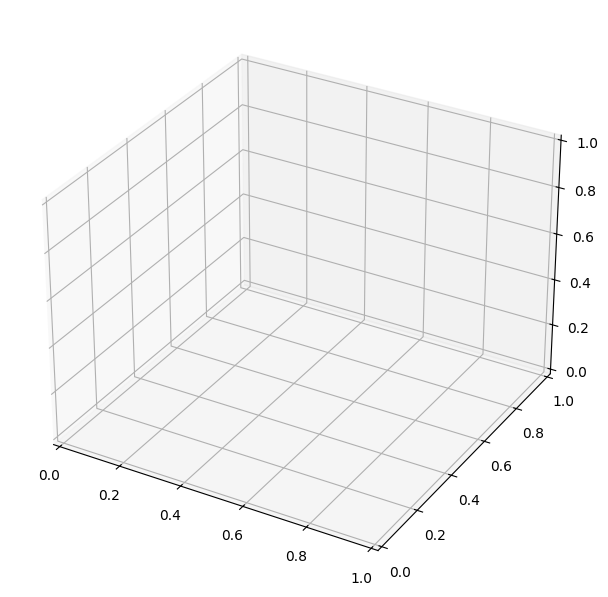

In [72]:
fig, ax = plt.subplots(figsize=(10, 7.5), subplot_kw={'projection': '3d'})
x_trans = best_pca.named_steps['pca'].transform(X_train)
ax.scatter(X_train_trans[:, 0], X_train_trans[:, 1], X_train_trans[:, 2], c=y_train)

plt.show()

## Test-Train Split

In [ ]:
TARGET_COL = "appts_per_person_per_workingday"

complete_dataset_df['month'].astype('category')


# remove SNEE ICBs from training set
training_dataset = complete_dataset_df.loc[
    ~complete_dataset_df.index.isin(list(const.SUB_ICB_CODES.keys()))
].copy()
test_set = complete_dataset_df.loc[
    complete_dataset_df.index.isin(list(const.SUB_ICB_CODES.keys()))
].copy()



# Split the dataset into features (X) and target variable (y)
X_train = training_dataset.copy().drop(columns=[TARGET_COL])
y_train = training_dataset[TARGET_COL]

X_test = test_set.copy().drop(columns=[TARGET_COL])
y_test = test_set[TARGET_COL]

### Baseline Model Metrics

In [ ]:
from src.appointments_models import MODEL_CONFIGS, baseline_scorer
from sklearn import set_config

set_config(transform_output='pandas')

baseline_scores = {}
for model_config in MODEL_CONFIGS:
    # fit
    print(model_config.name, 'start, fit')
    model_config.estimator.fit(X_train, y_train)
    # predict
    print('predict')
    y_preds = model_config.estimator.predict(X_test)
    # score
    print('score')
    baseline_scores[model_config.name] = baseline_scorer(y_test, y_preds)


print('Finished')
baseline_scores_df = pd.DataFrame(baseline_scores)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

best_params = {}
tuning_results = {}
for model_config in MODEL_CONFIGS:
    # Create the GridSearchCV object
    if model_config.name =='pca_ridge':
        grid_search = RandomizedSearchCV(estimator=model_config.estimator, param_distributions=model_config.grid_search_params,
                                        cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, error_score=np.nan, n_iter=50)

        print(model_config.name, 'start: fit')
        # Fit the grid search on the training data
        grid_search.fit(X_train, y_train)

        # Get the best parameters
        best_params[model_config.name] = grid_search.best_params_

        tuning_results[model_config.name] = grid_search.cv_results_

#### One hot encoding + PCA + Polynomial Features

In [ ]:
# residuals = real - preds
# colours = test_set["month"].values
# plt.scatter(preds, residuals, c=colours, cmap='viridis')
# plt.axhline(y=0, color='r', linestyle='--')
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.title('Residual Plot')
# plt.colorbar(label='Month')
# plt.show()


In [ ]:
# colours = {'06L':1,'06T':2,'07K':3}
# plt.scatter(preds, residuals, c=test_set.index.map(colours))
# plt.axhline(y=0, color='r', linestyle='--')
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals, Appointments per person per working day')
# plt.title('Residual Plot')
# plt.colorbar(label='ICB')
# plt.show()


### Load population estimate

In [ ]:
pop_projections = PopulationScenarios.read_yaml("outputs/population_projections.yaml")
scenario_names = pop_projections.scenarios
base_scenario = pop_projections.get_scenario(scenario_names[0])
base_scenario_df = base_scenario.as_dataframe()

## Transform

In [ ]:
# use the base scenario 

In [ ]:
base_scenario_df= base_scenario_df.reset_index().assign(month = 1).set_index(['area','year','month'])

In [ ]:
def convert_population_projection_to_model_input(scenario_df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts population projection data into model input format.

    Args:
        scenario_df (pd.DataFrame): The population projection data.

    Returns:
        pd.DataFrame: The population data in model input format.
    """
    df_ = scenario_df.copy()
    # create an empty dataframe with year and month as index with all the years and months 1-12
    expanded_index_df:pd.DataFrame = pd.DataFrame(index=pd.date_range(dt.date(df_.index.get_level_values('year').min(),month=1,day=1), # jan 1st of the first year
                                                      dt.date(df_.index.get_level_values('year').max(), month=12,day=1), # dec 1st of the last year
                                                        freq='M') # month frequency
                                                        ).assign(month=lambda df: df.index.month, year=lambda df: df.index.year) # add month and year columns
    # add areas
    monthly_areas_df:pd.DataFrame = pd.concat([expanded_index_df.assign(area=area) for area in base_scenario_df.index.get_level_values('area').unique()]).set_index(['area','year','month'])
    
    # merge the two dataframes and interpolate the missing values
    monthly_population_df =  (monthly_areas_df
            .join(df_,how='outer')
            .interpolate())
    # normalise the population
    monthly_population_df = monthly_population_df.div(monthly_population_df.sum(axis=1),axis=0)
    # move month back to a column
    monthly_population_df = monthly_population_df.reset_index().set_index(['area','year'])
    # return 
    return monthly_population_df




In [ ]:
model_input_df = convert_population_projection_to_model_input(base_scenario_df)

In [ ]:
model_input_df.assign(predicted_appointments_per_person_per_workingday= lambda df:population_model.predict(df))

In [ ]:
base_scenario_df

In [ ]:
base_scenario_df.sum(axis=1) * population_model.predict(model_input_df)